In [125]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
pd.options.mode.chained_assignment = None

Read the data and save it in a data frame type.

In [126]:
data_address='E:/data_analysis/data_science/mentoring-exercises/tennis match_test/data_tenniss_match/tables/'
match_away_team_df=pd.read_csv(data_address+'MatchAwayTeamInfo.csv')
match_home_team_df=pd.read_csv(data_address+'MatchHomeTeamInfo.csv')
event_df = pd.read_csv(data_address+'MatchEventInfo.csv')
match_time_df=pd.read_csv(data_address+'MatchTimeInfo.csv')
period_df=pd.read_csv(data_address+'PeriodInfo.csv')
tournament_df=pd.read_csv(data_address+'MatchTournamentInfo.csv')
power_df = pd.read_csv(data_address+'PowerInfo.csv')
home_score_df= pd.read_csv(data_address+ 'MatchHomeScoreInfo.csv')
away_score_df= pd.read_csv(data_address+ 'MatchAwayScoreInfo.csv')
game_df=pd.read_csv(data_address+'GameInfo.csv')


Some of rows of each tables are duplicates ,so for cleaning data we use drop_duplicates().

In [127]:
match_away_team_df.drop_duplicates(inplace=True)
match_home_team_df.drop_duplicates(inplace=True)
event_df.drop_duplicates(inplace=True)
match_time_df.drop_duplicates(inplace=True)
period_df.drop_duplicates(inplace=True)
tournament_df.drop_duplicates(inplace=True)
power_df.drop_duplicates(inplace=True)
game_df.drop_duplicates(inplace=True)


1.How many tennis players are included in the dataset?
 

We first concat two dfs based on their 'player_id', home and away teams informations. and count number of players by 'unique' function.

In [128]:
all_player_ids = pd.concat([match_away_team_df['player_id'], match_home_team_df['player_id']])
num_players = len(all_player_ids.unique())
print("Total number of players:",num_players)


Total number of players: 2352


2. What is the average height of the players?

At first,concatnate the coulmns 'height'and'player_id' of match_away_team_df and match_home_team_df tables to have a dataframe contain player_id and 'heit for each player in away _team and home_team ,we have duplicte player _id ,so we dop them,and some 'heigh'_value =0 that are replaced with null and then we drup 'nul' items.

In [129]:
height_player=pd.concat([match_away_team_df[['height','player_id']],match_home_team_df[['height','player_id']]])
height_player.drop_duplicates(inplace=True)
height_player.replace('0', pd.NA, inplace=True)
height_player.dropna(inplace=True)

With calculate value_counts() for 'player_id',we understand the height of some players has been recorded more than once.

In [130]:
player_id_value_count=height_player['player_id'].value_counts()

So we use the loop to drop extra rows

In [131]:

for id in height_player['player_id']:
    if player_id_value_count[id]>1:
        height_player = height_player.drop(height_player[height_player['player_id'].eq(id)].index)
height_player

,height,player_id
0,1.85,254742
1,1.98,90080
2,1.83,275923
4,1.98,57163
5,1.85,221012
...,...,...
13146,1.85,183823
13204,1.78,155684
13622,1.80,290624
13755,1.85,319992


Then calculate the mean of 'height'

In [132]:
height_player_mean=height_player['height'].mean()
print("Average height of players:",height_player_mean)

Average height of players: 1.8200083263946711


According to the given information, the average height of the players in this series of matches is 1.82

3. Which player has the highest number of wins?

We use 'game_df' that contains the points for each match seperated by games and sets. We sum all points per each match for away and home teams. Then if any of sum of points for home or away team is greater we consdier it as winner. 

In [133]:
point_count=game_df[['match_id','set_id','game_id','point_id','home_point','away_point']]

point_count.replace('A', '45' , inplace=True)
point_count['home_point'] = point_count['home_point'].astype(int)
point_count['away_point'] = point_count['away_point'].astype(int)

match_point_winner=point_count.groupby('match_id')[['home_point', 'away_point']].sum()
match_point_winner
match_point_winner['winner_code'] = 0
match_point_winner.loc[match_point_winner['home_point'] > match_point_winner['away_point'], 'winner_code'] = 1
match_point_winner.loc[match_point_winner['home_point'] < match_point_winner['away_point'], 'winner_code'] = 2
match_winner=match_point_winner.iloc[:,[2]]
match_point_winner.drop_duplicates(inplace=True)


We then use tha name of players take participate in each match. Evergy match has two players. We use this dataframe and the above df to have a tables containing match_id, home_points, away_points, winner_code and the player name that wins the match. The 'value_count' method is used to count the number of repeated player's names. Then using 'idxmax' get the name.

In [134]:
home_away_merged = pd.merge(match_home_team_df, match_away_team_df, on='match_id', how='inner', suffixes=('_player1', '_player2'))
match_players=home_away_merged[['match_id','name_player1', 'name_player2']]
match_players.drop_duplicates(inplace=True)
match_player_winner = pd.merge(match_players,match_point_winner, on='match_id', how='inner')
match_player_winner['winner_name'] =match_player_winner.apply(lambda row: row['name_player1'] if row['winner_code'] == 1.0 else row['name_player2'], axis=1)
match_player_winner

winner_player=match_player_winner['winner_name'].value_counts()
print(f"The player with the most winnings in matches is: ", winner_player.idxmax())
print(f"The number of winnings for the player is: ", winner_player.max())
print (winner_player)

The player with the most winnings in matches is:  Uchijima M.
The number of winnings for the player is:  15
winner_name
Uchijima M.          15
Sherif M.            13
Urhobo A.            12
Sun F.               12
Wiskandt M.          12
                     ..
Militi Ribaldi A.     1
Shimabukuro S.        1
Di Natale G.          1
Puskar S.             1
Zaar L.               1
Name: count, Length: 1615, dtype: int64


4. What is the longest match recorded in terms of duration?

We use match_time_df that has the time information of matches. We first fill the 'Nan' values and remove the duplicated records.

In [135]:
match_time_df.fillna(0,inplace=True)
match_time_df.drop_duplicates(inplace=True)

Then we seperate the columns for periods and obtain the sum of them. The next step get the maximum sum of times.

In [136]:

match_time_df['sumation_time_periods_match']=match_time_df.iloc[:,[1,2,3]].sum(axis=1)
match_time_df.head()

,match_id,period_1,period_2,period_3,period_4,period_5,current_period_start_timestamp,sumation_time_periods_match
0,12260075,3463.0,3855.0,0.0,0.0,0.0,1.714511e+09,7318.0
1,12260076,3032.0,2121.0,2674.0,0.0,0.0,1.714492e+09,7827.0
2,12260077,2747.0,3525.0,4074.0,0.0,0.0,1.714492e+09,10346.0
3,12260078,2519.0,2531.0,2121.0,0.0,0.0,1.714578e+09,7171.0
4,12260080,2616.0,2766.0,0.0,0.0,0.0,1.714483e+09,5382.0


We get the max and then find the corresponding match that has the maximum time duration. Then print the match with detail information.

In [137]:
longest_time=match_time_df['sumation_time_periods_match'].max()
longest_match=match_time_df.loc[(match_time_df['sumation_time_periods_match']==longest_time),:]
longest_match

,match_id,period_1,period_2,period_3,period_4,period_5,current_period_start_timestamp,sumation_time_periods_match
13350,12346747,167761.0,3392.0,0.0,0.0,0.0,1.716382e+09,171153.0


According to the given information ,the longest match recorded in terms of duration is the match with match-id:12346747 

5. How many sets are typically played in a tennis match?

We use the power_df that has the number of sets for each match. We groupby the power_df by 'match_id' and then count the unique sets of a match.

In [138]:
power_df.head()
num_sets_per_match = power_df.groupby('match_id')['set_num'].nunique()
print(num_sets_per_match)
num_sets_per_match.mode()

match_id
12260075    2
12260076    3
12260077    3
12260078    3
12260080    2
           ..
12384789    2
12384806    3
12384892    2
12384975    3
12385017    3
Name: set_num, Length: 6658, dtype: int64


0    2
Name: set_num, dtype: int64

As advantage, 2 sets typically played in a tennis match in this matche.

6. Which country has produced the most successful tennis players?

We need to merge tha 'home_team_info' and 'away_team_info' dataframes. Then we merge the result with the 'match_point_winner' we created before. The result df called 'playerWinner' contains 'match_id', 'name_player1', 'name_player', 'country_player1', 'country_player2', 'winner_code' and 'winner_name'. We then add the 'winner_country' considering the 'winner_name'. Then we count the number of countries and take the maximum of them as the answer.

In [139]:
merged_player = pd.merge(match_away_team_df, match_home_team_df, on='match_id',how='inner', suffixes=('_player1', '_player2'))
merged_match_id_name_country=merged_player[['match_id','name_player1', 'name_player2','country_player1','country_player2']]

playerWinner = pd.merge(merged_match_id_name_country, match_point_winner, on='match_id', how='inner')

playerWinner['winner_name'] = playerWinner.apply(lambda row: row['name_player1'] if row['winner_code'] == 1.0 else row['name_player2'], axis=1)
playerWinner['winner_country'] = playerWinner.apply(lambda row: row['country_player1'] if row['winner_code'] == 1.0 else row['country_player2'], axis=1)

winner_country = playerWinner['winner_country'].value_counts()
print(f"The player who wins the most matches is:", winner_country.idxmax())
winner_country

The player who wins the most matches is: Italy


winner_country
Italy          1029
USA             940
France          918
Japan           601
Germany         594
               ... 
Iran              1
Qatar             1
Kenya             1
Ivory Coast       1
Azerbaijan        1
Name: count, Length: 93, dtype: int64

According to the above results, if the criterion for determining a successful player is the number of wins in this series of tournaments, it can be claimed that 'France' with '463'winns ,cultivates the most successful tennis players.

Also we can choose the succesful players by ranking,so we sort countries by their player ranking and filter 5-top-ranking players 

In [140]:
country_current_rank=pd.concat([match_away_team_df[['name','country','current_rank']],match_home_team_df[['name','country','current_rank']]]).sort_values('current_rank').drop_duplicates().dropna().iloc[:,:]
country_current_rank.loc[country_current_rank['current_rank']<4 ,:]


,name,country,current_rank
4590,Świątek I.,Poland,1.0
13327,Djokovic N.,Serbia,1.0
4320,Sabalenka A.,Belarus,2.0
12694,Sinner J.,Italy,2.0
5165,Gauff C.,USA,3.0
10580,Alcaraz C.,Spain,3.0


We have various countries for the best ranking, so we can not clime wich of them have the most successful players.
So we culculate the mean of current_rank for each country.

In [141]:
country_current_rank.drop(columns='name',inplace=True)
country_mean_rank=country_current_rank.groupby('country',as_index=False).mean().sort_values('current_rank').head()
country_mean_rank

,country,current_rank
69,Philippines,161.000000
1,Andorra,294.666667
55,Malta,330.500000
83,Syria,344.000000
13,Burundi,371.000000


According 'country_mean_rank' table , 'Philippines' has the best mean rank compared to other countries,so if the criteria for being a successful player is the top rank,maybe we can claim that the 'Philippines' produces more successful players

7. What is the average number of aces per match?

We use period_info dataframes containing the 'statistic_name'. We select rows that their 'statistic_name' is 'aces'. Then we sum the 'home_value' and 'away_value'. The next step is to get the number pf matches by 'nunique' method. The average aces per match is get by dividing the total_aces by number of matches. 

In [142]:

aces_stats = period_df[period_df['statistic_name'] == 'aces']
total_aces = aces_stats['home_value'].sum() + aces_stats['away_value'].sum()

num_matches = event_df['match_id'].nunique()
average_aces_per_match = total_aces / num_matches

print(f"The average number of aces per match is: ", average_aces_per_match)

The average number of aces per match is:  6.061165361090246


8. Is there a difference in the number of double faults based on gender?

We need the concatenation of home team information df and away team information df. Then we join the resulted concat df with period_df on match_id. This gives us a dataframe contains matches with their players and the corresponding 'statistic_name' and other usefull information like 'gender'. We then get the mean of 'home_value' and 'away_value' groupby gender field.
To have a schematic view of the results we plot a histogram presenting the results seperated by gender. 

<Figure size 800x600 with 0 Axes>

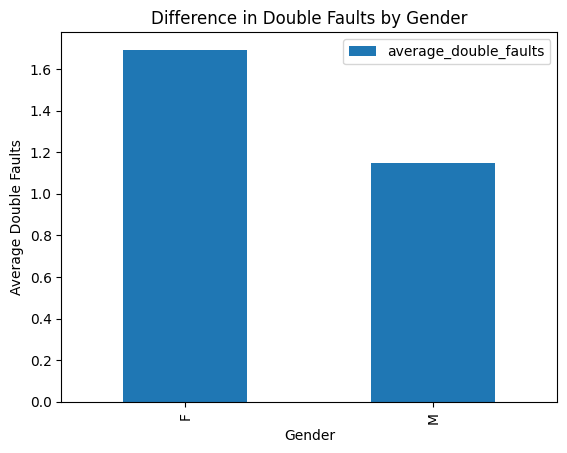

,gender,home_value,away_value,average_double_faults
0,F,1.650679,1.734638,1.692658
1,M,1.109402,1.186400,1.147901


In [143]:
players_id_concat = pd.concat([match_away_team_df, match_home_team_df])
period_df.fillna(0)

player_period_merged = pd.merge(players_id_concat, period_df, on='match_id')
double_faults_stats = player_period_merged[player_period_merged['statistic_name'] == 'double_faults']

gender_double_faults = double_faults_stats.groupby('gender')[['home_value', 'away_value']].mean().reset_index()
gender_double_faults['average_double_faults'] = (gender_double_faults['home_value'] + gender_double_faults['away_value']) / 2

plt.figure(figsize=(8, 6))
gender_double_faults.plot( x='gender', y='average_double_faults' ,kind='bar')

plt.xlabel('Gender')
plt.ylabel('Average Double Faults')
plt.title('Difference in Double Faults by Gender')
plt.show()

gender_double_faults

In conclusion of the given information, there is a difference between male and female in the number of double faults. The average double faults value is more in females than in males.

9. Which player has won the most tournaments in a single month?

We use the playerWinner dataframe previousely produced in question 3. It contains 'match_id', 'name_player1', 'name_player2' and 'winner_name' fields. Now we join this dataframe with the MatchTournamentInfo dataframe to get the player who won the most tournaments.

In [144]:

playerWinnerTourn = pd.merge(playerWinner, tournament_df, on='match_id', how='inner')
playerWinnerTourn=playerWinnerTourn[['match_id','name_player1','name_player2','tournament_id','winner_name']]
playerWinnerTourn

player_wins = playerWinnerTourn.groupby('winner_name').size().reset_index(name='wins')
player_wins = player_wins.sort_values(by='wins', ascending=False)
print(f"The player who wins the most tournaments is:", player_wins.iloc[0]['winner_name'])

The player who wins the most tournaments is: Paquet C.


10. Is there a correlation between a player's height and their ranking?

Again we need a concatenation of home team information and away team information. We then use the 'height' column and the 'current_rank' columns to get the correlation using 'corr' method. 
To have a schematic view of the results we plot the scatter plot for the height and the mean of corresponding 'current rank'. The results show that there is no correlation between height and rank.

The correlation between height and ranking is:  0.10743548957985272


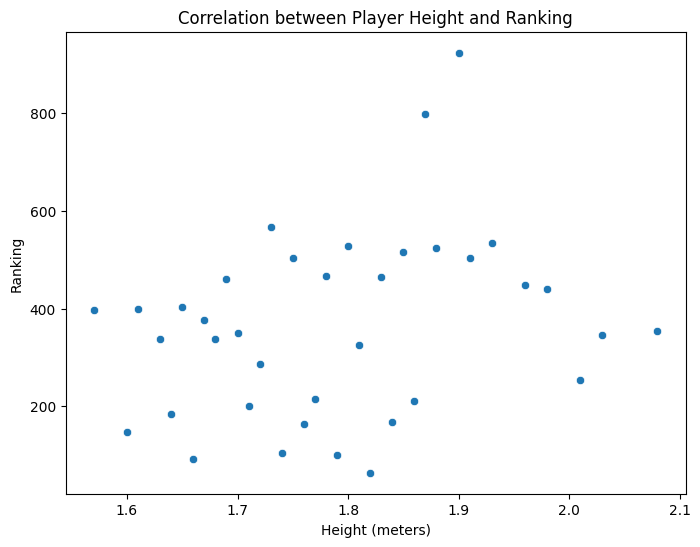

In [145]:
players_concat_df = pd.concat([match_away_team_df, match_home_team_df])
height_rank_correlation=players_concat_df['height'].corr(players_concat_df['current_rank'])

print("The correlation between height and ranking is: ", height_rank_correlation)

height_rank_mean = players_concat_df.groupby('height')['current_rank'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='height', y='current_rank', data=height_rank_mean)

plt.xlabel('Height (meters)')
plt.ylabel('Ranking')
plt.title('Correlation between Player Height and Ranking')
plt.show()

According to the scatter plot and height_rank_correlation value, it cannot be claimed that there is a correlation between players height and their rank.

11. What is the average duration of matches?

We use time_df that has the duration of each period. We then get the average by dividing this value on number of matches.

In [146]:

match_time_df.fillna(0,inplace=True)
total_duration = match_time_df['period_1'].sum() +match_time_df['period_2'].sum() + match_time_df['period_3'].sum()
num_matches = match_time_df['match_id'].nunique()

average_duration = total_duration / num_matches

print(f"The average duration of matches is {average_duration / 60:.2f} minutes.")

The average duration of matches is 156.93 minutes.


12. What is the average number of games per set in men's matches compared to women's matches?

We use power_df that has the match_id, the number of sets and number of games in each set, and the concatenation of home information team and away information team. 
We get the total games per set considering the maximum number of games.

In [147]:

power_player_id = pd.merge(power_df, players_id_concat, on='match_id')

total_games_per_set = power_player_id.groupby(['match_id', 'set_num', 'gender'])['game_num'].max()
total_games_per_set


match_id  set_num  gender
12260075  1        M         12
          2        M         10
12260076  1        M         12
          2        M          9
          3        M          9
                             ..
12384975  2        F         13
          3        F         10
12385017  1        F         10
          2        F         12
          3        F         12
Name: game_num, Length: 14406, dtype: int64

We compute the average number of games per set by mean method seperated with gender.

In [148]:
gender_games_per_set = total_games_per_set.groupby('gender').mean()

print(f"The average number of games per set in men's matches is {gender_games_per_set['M']:.2f}.")
print(f"The average number of games per set in women's matches is {gender_games_per_set['F']:.2f}.")

The average number of games per set in men's matches is 9.18.
The average number of games per set in women's matches is 8.92.


On average, in men's matches, each set has 18 games and in women's matches, each set has 17 games

13. What is the distribution of left-handed versus right-handed players?

We first clean the data of match away team and home away team then merge them. Then we use 'value_count' method to count the right-handed players and 'left-handed' players seperately.
To have a schematic view of resulted distribution of right-handed players versus left-handed players we plot a histogram. As it can be seen the left-handed players are less than right-handed, considerably.

The distribution of right-handed players versus left-handed: plays
right-handed    908
left-handed     120
ambidextrous      1
Name: count, dtype: int64
The percentage of the distribution of right-handed players versus left-handed: plays
right-handed    88.241011
left-handed     11.661808
ambidextrous     0.097182
Name: count, dtype: float64


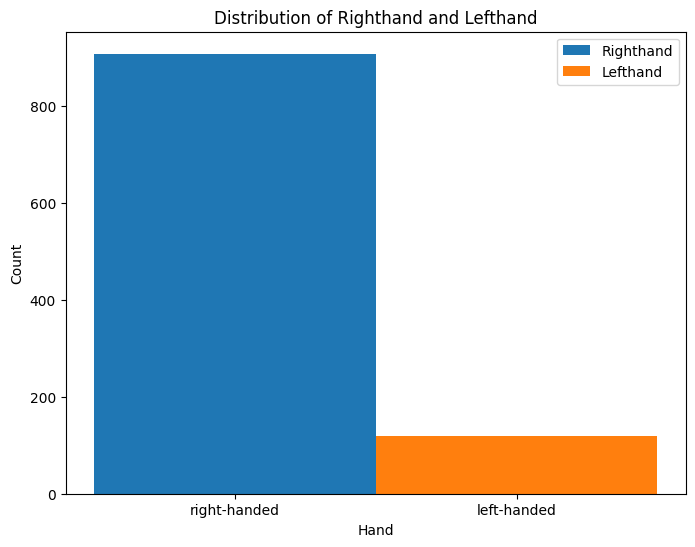

In [149]:
match_away_cleand_df = match_away_team_df.loc[match_away_team_df['plays'].notnull()]

match_home_cleand_df = match_home_team_df.loc[match_home_team_df['plays'].notnull()]



match_home_away_df = pd.concat([match_away_cleand_df, match_home_cleand_df])
match_home_away_cleaned_df = match_home_away_df[['player_id','plays']]

match_home_away_cleaned_df.drop_duplicates(inplace=True)
distribution = match_home_away_cleaned_df['plays'].value_counts()

print("The distribution of right-handed players versus left-handed:",distribution)

percentage_distribution = (distribution / len(match_home_away_cleaned_df)) * 100
print("The percentage of the distribution of right-handed players versus left-handed:",percentage_distribution)
righthand_data = match_home_away_cleaned_df.loc[match_home_away_cleaned_df['plays'] == 'right-handed']
lefthand_data = match_home_away_cleaned_df.loc[match_home_away_cleaned_df['plays'] == 'left-handed']
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(righthand_data['plays'], bins=1, label='Righthand')
ax.hist(lefthand_data['plays'], bins=1, label='Lefthand')
ax.set_xlabel('Hand')
ax.set_ylabel('Count')
ax.set_title('Distribution of Righthand and Lefthand')

ax.legend()
plt.show()

14. What is the most common type of surface used in tournaments?

We use 'tournament_df' to get the 'ground_type'. By plotting a bar plot for Tournament Surface Types' we can get the most common surface that is 'Red clay'.

ground_type
Red clay             14238
Hardcourt outdoor     4606
Hardcourt indoor       241
Synthetic outdoor       93
Name: count, dtype: int64


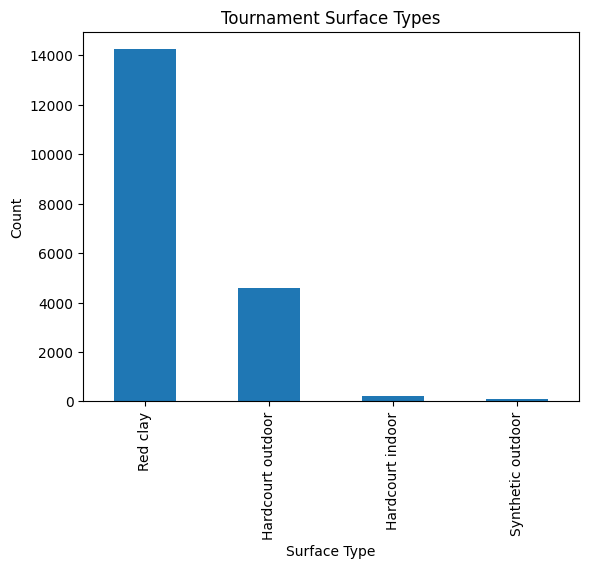

In [150]:

tournament_df.drop_duplicates(inplace=True)
print(tournament_df['ground_type'].value_counts())

tournament_df['ground_type'].value_counts().plot(kind='bar')
plt.title('Tournament Surface Types')
plt.xlabel('Surface Type')
plt.ylabel('Count')
plt.show()

The most common type of surface used in the tournaments is 'Red clay' that used in '14238' tournaments

15. How many distinct countries are represented in the dataset?

For this question we used the field 'Country' in the team infos dataframes. We use 'nunique' to get the number of unique countries in the dataframes.

In [153]:
num_distinct_countries = match_home_away_df['country'].nunique()

print(f"The dataset contains {num_distinct_countries} distinct countries.")

The dataset contains 80 distinct countries.


16. Which player has the highest winning percentage against top 10 ranked opponents?

At first, we find the top ten players by selecting the names of the players and sorting them according to their rank by using concatenate of tables : 'match_home_team' and 'match_away_team' .


In [ ]:
country_current_rank=pd.concat([match_away_team_df[['name','current_rank']],match_home_team_df[['name','current_rank']]]).sort_values('current_rank').drop_duplicates().dropna().iloc[0:12,:]
top_10_players=country_current_rank['name'].unique()
top_10_players

array(['Świątek I.', 'Djokovic N.', 'Sabalenka A.', 'Sinner J.',
       'Gauff C.', 'Alcaraz C.', 'Zverev A.', 'Medvedev D.',
       'Rybakina E.', 'Vondroušová M.'], dtype=object)

Then using the columns 'home_point' and 'away_point' from 'game_info' table, calculating the sumation of points for home_team and 'away _team for each match _id. We create 'winner_code' by using 'home_point' and 'away_point' that contains '1' if 'home_point' is more than 'away_point'and indicates that home_team is winner and '2' indicate that 'away_team' is winner.
*Milestone:
As these columns are string-type, for getting proper summation changing them to integer is mandatory.
These columns also contains the character 'A' ,that for executing procedures,  replaced by '45'.

In [ ]:
point_count=game_df[['match_id','home_point','away_point']]
point_count.replace('A', '45' , inplace=True)
point_count['home_point'] = point_count['home_point'].astype(int)
point_count['away_point'] = point_count['away_point'].astype(int)

match_point_winner=point_count.groupby('match_id')[['home_point', 'away_point']].sum()
match_point_winner
match_point_winner['winner_code'] = 0
match_point_winner.loc[match_point_winner['home_point'] > match_point_winner['away_point'], 'winner_code'] = 1
match_point_winner.loc[match_point_winner['home_point'] < match_point_winner['away_point'], 'winner_code'] = 2
match_winner=match_point_winner.iloc[:,[2]]
match_point_winner

,home_point,away_point,winner_code
match_id,,,
12260075,2600,2810,2
12260076,3025,2880,1
12260077,4213,4441,2
12260078,7120,5920,1
12260080,2275,2100,1
...,...,...,...
12384789,2860,3285,2
12384806,4089,3504,1
12384892,1955,2095,2


By using above table and merged it with 'match_home_team' and 'match_away_team',we have 'match_player_winner' table contains''match_id','name_player1', 'name_player2' and 'winner_code'.
Then we add two columns 'winner_name' and 'loser_name' using 'lambda',according 'winner_code', we can set player names in these columns.


In [ ]:
home_away_merged = pd.merge(match_home_team_df, match_away_team_df, on='match_id', how='inner', suffixes=('_player1', '_player2'))
match_players=home_away_merged[['match_id','name_player1', 'name_player2']]
match_player_winner = pd.merge(match_players,match_winner, on='match_id', how='inner')
match_player_winner

match_player_winner['winner_name'] =match_player_winner.apply(lambda row: row['name_player1'] if row['winner_code'] == 1.0 else row['name_player2'], axis=1)
match_player_winner['loser_name'] = match_player_winner.apply(lambda row: row['name_player1'] if row['winner_code'] == 2.0 else row['name_player2'], axis=1)

player_winner_loser=match_player_winner.iloc[:,[0,4,5]]
player_winner_loser

,match_id,winner_name,loser_name
0,12260075,Lehečka J.,Nadal R.
1,12260076,Sinner J.,Khachanov K.
2,12260077,Alcaraz C.,Struff J.
3,12260078,Rublev A.,Alcaraz C.
4,12260078,Rublev A.,Alcaraz C.
...,...,...,...
24555,12384789,Léonard M.,Kostic T.
24556,12384806,Kasnikowski M.,Dutra da Silva D.
24557,12384892,Gomez F.,Chazal M.
24558,12384975,Șerban R.,Bandecchi S.


Now by using the list of 'top_10_players' and 'player_winner_loser' table, we can filter 'match_id's in which top_10_players are loser. Then by using value_counts(), calculate the number of winning against 'top_10_players' for each winner_name and its percentage,
After that, filter 'winner_name' with the highest winning percentage against top 10 ranked opponents by using 'idxmax()'.

In [ ]:
top_10_matches =player_winner_loser[(player_winner_loser['loser_name'].isin(top_10_players))]
top_10_matches.drop_duplicates(inplace=True)
top_10_matches_winner=top_10_matches.iloc[:,[0,1]]

winner_counts = top_10_matches_winner['winner_name'].value_counts()
winner_percentages = (winner_counts / len(top_10_matches_winner)) * 100

player_with_highest_win = winner_percentages.idxmax()
highest_win_pct = winner_percentages.max()

print(f"The player with the highest winning percentage against top 10 ranked opponents is:", player_with_highest_win, "with", highest_win_pct, "percent win")
winner_counts


The player with the highest winning percentage against top 10 ranked opponents is: Świątek I. with 16.666666666666664 percent win


Świątek I.      3
Rublev A.       1
Cerundolo F.    1
Lehečka J.      1
Sabalenka A.    1
Moutet C.       1
Tabilo A.       1
Cîrstea S.      1
Badosa P.       1
Međedović H.    1
Fritz T.        1
Fręch M.        1
Kalinina A.     1
Volynets K.     1
Rus A.          1
Machač T.       1
Name: winner_name, dtype: int64

17. What is the average number of breaks of serve per match? 

We use the power_df dataframe(for PowerInfo table) that has the information for breaks of matches.

In [ ]:
total_breaks = power_df['break_occurred'].sum()

num_matches = power_df['match_id'].nunique()

average_breaks_per_match = total_breaks / num_matches
print(f"the average is: ",average_breaks_per_match )

the average is:  16.370381495944727


EXTRA QUESTION 1- Is there a correlation between a player's experience and their ranking?

We use the year that players started to play tennis, substracting it from the current year (2024) and then find the relation with 'current_rank' field for each player. The scatter plot shows that there is a very weak relation between these two parameters.

In [ ]:
match_home_team_turned_rank_df=match_home_team_df.iloc[:,[17,10,14]]
match_away_team_turned_rank_df=match_away_team_df.iloc[:,[17,10,14]]
turned_rank_player=pd.concat([match_home_team_turned_rank_df,match_away_team_turned_rank_df])
turned_rank_player.drop_duplicates()
turned_rank_player.dropna(inplace=True)
turned_rank_player['experience'] = 2024-turned_rank_player['turned_pro']
turned_rank_player.drop(columns='turned_pro', inplace=True)
turned_rank_player.drop_duplicates(inplace=True)
turned_rank_player.sort_values('current_rank')

,full_name,current_rank,experience
498,"Swiatek, Iga",1.0,8.0
4570,"Djokovic, Novak",1.0,21.0
8,"Sabalenka, Aryna",2.0,9.0
1,"Sinner, Jannik",2.0,6.0
2,"Alcaraz, Carlos",3.0,6.0
...,...,...,...
5879,"Gabashvili, Teimuraz",1272.0,23.0
4822,"Uzhylovsky, Vladimir",1341.0,19.0
42,"Clezar, Guilherme",1365.0,15.0
3447,"Gabashvili, Teimuraz",1452.0,23.0


There is a weak correlation between players experience and there rank


Text(0.5, 1.0, 'correlation between players and their ranks')

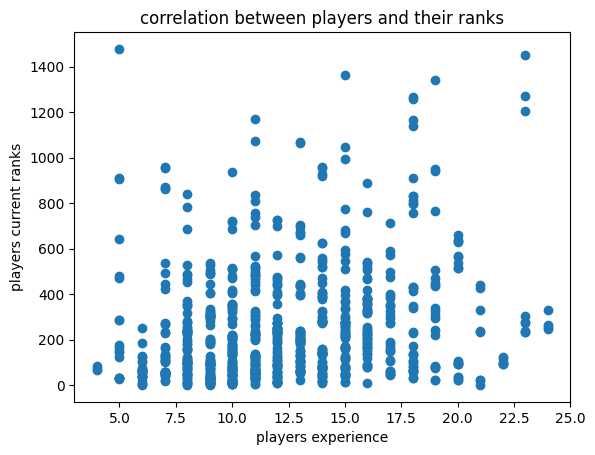

In [ ]:
experience_rank_correlation=turned_rank_player['experience'].corr(turned_rank_player['current_rank'])
if experience_rank_correlation < 0.3:
    print('There is a weak correlation between players experience and there rank')
elif 0.3<experience_rank_correlation<0.5:
    print('There is a moderate correlation between players experience and there rank')
else:
    print('There is a strong correlation between players experience and there rank')

plt.scatter(turned_rank_player['experience'],turned_rank_player['current_rank'])
plt.xlabel('players experience')
plt.ylabel('players current ranks')
plt.title('correlation between players experience and their ranks')

EXTRA QUESTION 2- Is there a any diffrence between right/left handedness and number of ranking?

We groupby players by their playing styles, 'left_handed' or 'right_handed'. Then we compute the average of their rank. The results show that the average rank is better in the 'right_handed' players.

In [ ]:
handedness_ranking = players_concat_df .groupby('plays')['current_rank'].mean()

print(f"Right-handed players have an average ranking of {handedness_ranking['right-handed']:.2f}.")
print(f"Left-handed players have an average ranking of {handedness_ranking['left-handed']:.2f}.")

Right-handed players have an average ranking of 365.35.
Left-handed players have an average ranking of 372.34.


EXTRA QUESTION 3- Which three players received the most prize money in tennis matches? 


We use prize field for each player from the home/away team info.

In [ ]:
country_total_prize=pd.concat([match_away_team_df[['full_name','total_prize']],match_home_team_df[['full_name','total_prize']]]).drop_duplicates()
country_total_prize.groupby('full_name').sum().sort_values('total_prize',ascending=False).iloc[0:3,:]

,total_prize
full_name,
"Djokovic, Novak",455008686.0
"Nadal, Rafael",224653134.0
"Murray, Andy",107560350.0


EXTRA QUESTION 4- How does the average number of winners per match differ between hard and clay court surfaces?

The results got from the merge of event_df and tournament_df. We then group the result by the ground type and obtain the winner code for each type. Results shows that 'Red clay' ground provides more winners in compare with 'HardCourt outdoor'.

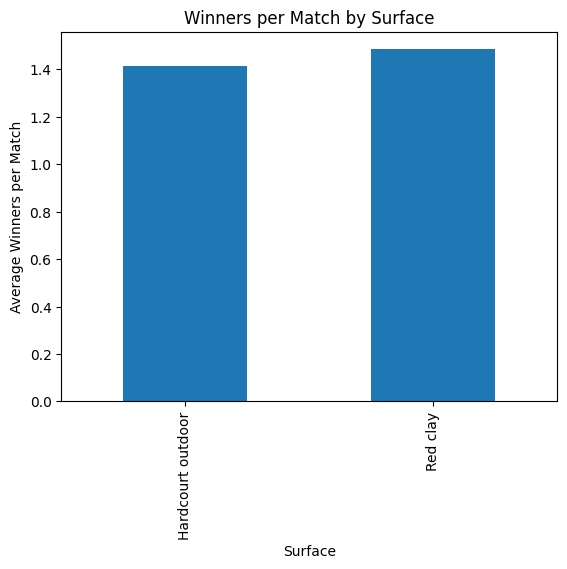

In [ ]:
df_combined = pd.merge(event_df, tournament_df, on='match_id')
surface_winners = df_combined.groupby('ground_type')['winner_code'].mean()

surface_winners.plot(kind='bar')
plt.xlabel('Surface')
plt.ylabel('Average Winners per Match')
plt.title('Winners per Match by Surface')
plt.show()


EXTRA QUESTION 5- What is the number of winning matches for each player?

We use the produced results before we had in questions 5 and 16. We just print the results.

In [ ]:
player_winner_loser.drop_duplicates(inplace=True)
winner_player=player_winner_loser['winner_name'].value_counts()

winner_player


Uchijima M.       15
Sherif M.         13
Sun F.            12
Urhobo A.         12
Wiskandt M.       12
                  ..
Shimabukuro S.     1
Di Natale G.       1
Puskar S.          1
Bol J.             1
Zaar L.            1
Name: winner_name, Length: 1623, dtype: int64

For example Uchijima M. won 15 times in matches.

EXTRA QUESTION 6- Which country has the most number of players? 

Again we group by matches with the 'country' field in the concatenation of home/away teams info we can get the correct result.

In [ ]:
player_counts = players_concat_df.groupby('country')['player_id'].nunique()
player_counts

top_country = player_counts.idxmax()
num_players = player_counts.max()

print(f"The country with the most number of players is {top_country} with {num_players} players.")
player_counts.sort_values(ascending=False)

The country with the most number of players is USA with 208 players.


country
USA                         208
Italy                       181
France                      153
Japan                       122
Russia                      118
                           ... 
Malta                         1
New Caledonia                 1
Senegal                       1
Northern Mariana Islands      1
Kyrgyzstan                    1
Name: player_id, Length: 97, dtype: int64

EXTRA QUESTION 7- Is there a correlation between Height and weight ratio and ranking value?

We compute the correlation of BMI of players and their current ranking. Again we use the home/away team info to get the results.

In [ ]:
match_home_rank_df=match_home_team_df.iloc[:,[13,3,7,8,14]]
match_away_rank_df=match_away_team_df.iloc[:,[13,3,7,8,14]]
height_weight_rank_player=pd.concat([match_home_rank_df,match_away_rank_df])
height_weight_rank_player.dropna(inplace=True)
height_weight_rank_player.drop_duplicates(inplace=True)

height_weight_rank_player['BMI']=(height_weight_rank_player['weight'])/((height_weight_rank_player['height']*100)**2)
height_weight_rank_player.sort_values('current_rank')

,player_id,gender,height,weight,current_rank,BMI
4570,14882,M,1.88,77.0,1.0,0.002179
1,206570,M,1.88,68.0,2.0,0.001924
2,275923,M,1.83,68.0,3.0,0.002031
6761,57163,M,1.98,90.0,4.0,0.002296
497,163504,M,1.98,83.0,4.0,0.002117
...,...,...,...,...,...,...
7245,214341,M,1.88,78.0,1496.0,0.002207
3393,198203,M,1.93,88.0,1497.0,0.002362
6071,214341,M,1.88,78.0,1499.0,0.002207
1343,63222,M,1.85,77.0,1500.0,0.002250


There is a weak correlation between players BMI and their rank


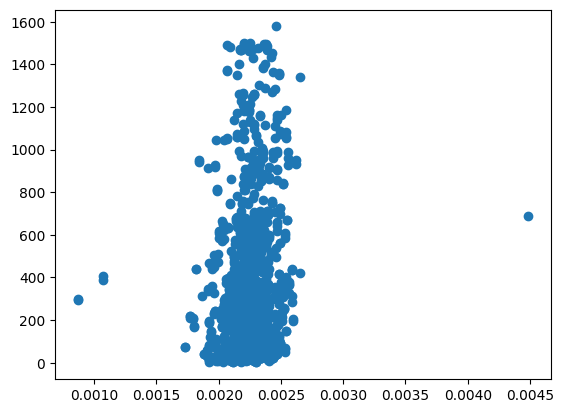

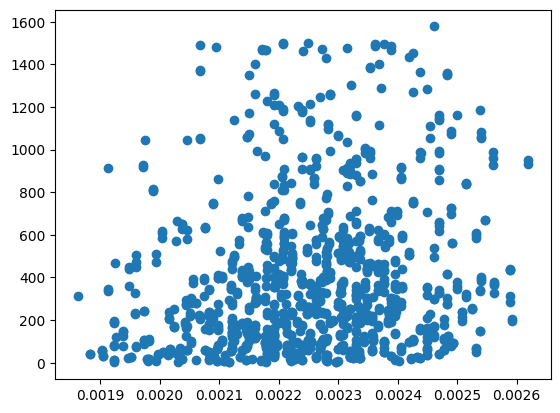

In [ ]:
BMI_rank_correlation=height_weight_rank_player['BMI'].corr(height_weight_rank_player['current_rank'])
if BMI_rank_correlation <0.3:
    print('There is a weak correlation between players BMI and their rank')
elif 0.3<BMI_rank_correlation<0.5:
    print('There is a moderate correlation between players BMI and their rank')
else:
    print('There is a strong correlation between players BMI and their rank')

# Scatter plot before remove outliers
plt.scatter(height_weight_rank_player['BMI'],height_weight_rank_player['current_rank'])
Q1 = height_weight_rank_player['BMI'].quantile(0.25)
Q3 = height_weight_rank_player['BMI'].quantile(0.75)
IQR = Q3 - Q1
height_weight_rank_player = height_weight_rank_player[~((height_weight_rank_player['BMI'] < (Q1 - 1.5 * IQR)) | (height_weight_rank_player['BMI'] > (Q3 + 1.5 * IQR)))]
plt.show()
#Scatter plot after remove outliers
plt.scatter(height_weight_rank_player['BMI'],height_weight_rank_player['current_rank'])
plt.show()


EXTRA QUESTION 8- Find the distribution of the 'current_score' values in the df_home_score and df_away_score DataFrames.

According to the results the 'current_score' distribution is not normal. It has right skewness.

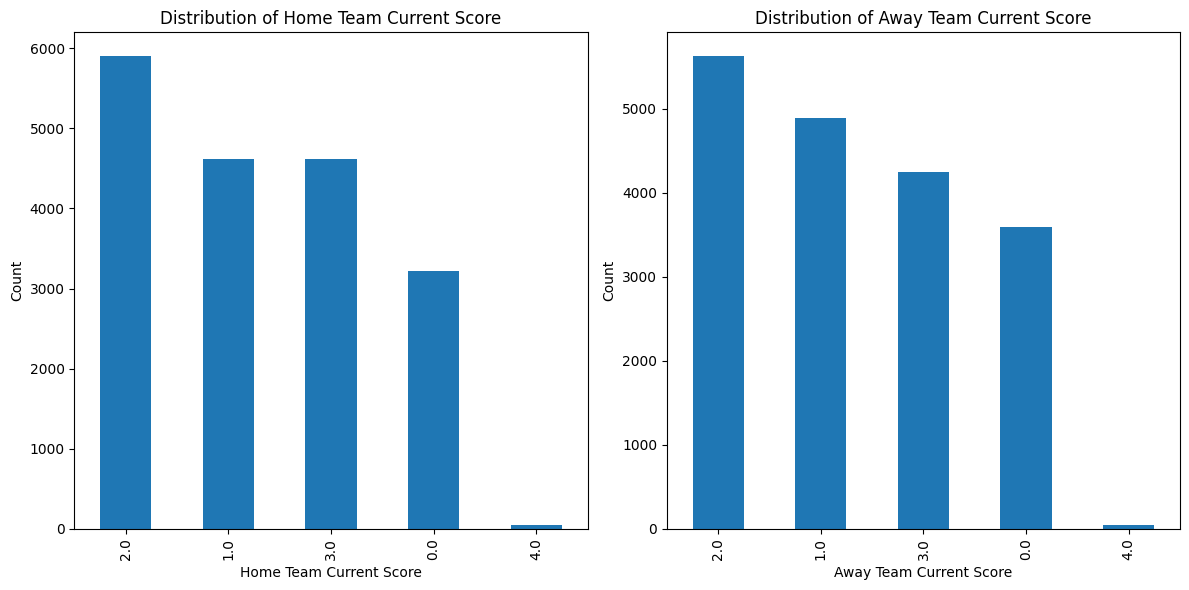

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
home_score_df['current_score'].value_counts().plot(kind='bar')
plt.xlabel('Home Team Current Score')
plt.ylabel('Count')
plt.title('Distribution of Home Team Current Score')

plt.subplot(1, 2, 2)
away_score_df['current_score'].value_counts().plot(kind='bar')
plt.xlabel('Away Team Current Score')
plt.ylabel('Count')
plt.title('Distribution of Away Team Current Score')

plt.tight_layout()
plt.show()


The plots show that the distribution of the 'current_score' in both away_score df and home_score df is not normal. 